In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV

import utils.data
import utils.correlation


---------


# Classifier on Correlation Matrix

In [3]:
control_data = utils.data.batch_read('../data/Controls_columns')
prodomal_data = utils.data.batch_read('../data/Prodomals_columns')
parkinson_data = utils.data.batch_read('../data/PDs_columns')

> Selecting only BOLD timeseries from AAL3 atlas.

In [4]:
control_AAL3_data = utils.data.select_atlas_columns(control_data, 'AAL3')
prodomal_AAL3_data = utils.data.select_atlas_columns(prodomal_data, 'AAL3')
parkinson_AAL3_data = utils.data.select_atlas_columns(parkinson_data, 'AAL3')

control_AAL3_data[0].head()

,AAL3.cluster001,AAL3.cluster002,AAL3.cluster003,AAL3.cluster004,AAL3.cluster005,AAL3.cluster006,AAL3.cluster007,AAL3.cluster008,AAL3.cluster009,AAL3.cluster010,...,AAL3.cluster161,AAL3.cluster162,AAL3.cluster163,AAL3.cluster164,AAL3.cluster165,AAL3.cluster166,AAL3.cluster167,AAL3.cluster168,AAL3.cluster169,AAL3.cluster170
0,-0.060492,-0.064699,0.027009,0.006356,0.064636,0.025074,-0.072370,-0.023259,0.030439,0.141354,...,-0.128405,-0.212190,0.071778,-0.085851,-0.369906,-0.227215,0.218964,0.143408,0.114787,0.086331
1,0.004386,-0.048182,-0.005618,-0.001391,-0.028455,0.004416,0.008140,-0.016648,-0.002957,0.110977,...,0.121169,0.002904,0.144537,-0.160525,0.209921,0.348922,-0.037231,0.342327,0.182087,-0.142731
2,0.020226,-0.028979,-0.017380,0.002162,-0.063357,0.000866,0.041881,0.002447,-0.014558,0.048355,...,0.242692,0.082687,0.049029,-0.125446,0.396209,0.546062,-0.140805,0.501917,0.402791,-0.298033
3,-0.051301,-0.017008,0.021943,0.026391,0.032551,0.023242,-0.035161,0.014269,0.024234,-0.009537,...,0.064849,-0.150406,-0.138013,0.020100,-0.285842,-0.085880,0.057809,0.427078,0.668149,-0.168126
4,-0.096539,-0.009171,0.079801,0.052421,0.142671,0.025372,-0.122511,-0.020408,0.075939,-0.014011,...,-0.111373,-0.411528,0.032230,0.015906,-1.012333,-0.702678,0.194447,0.166741,0.575768,0.124174


> Building the Connectivity Matrix using Pearson Correlation

In [5]:
control_correlation_matrix = utils.correlation.pearson_correlation(control_AAL3_data)
prodomal_correlation_matrix = utils.correlation.pearson_correlation(prodomal_AAL3_data)
parkinson_correlation_matrix = utils.correlation.pearson_correlation(parkinson_AAL3_data)


> From the Connectivity matrix, we will use only the upper triangle to reduce redundancy. This is due to the fact that the matrix is symmetrical.

In [6]:
control_triu_data = utils.data.get_triu(control_correlation_matrix, k=1)
prodomal_triu_data = utils.data.get_triu(prodomal_correlation_matrix, k=1)
parkinson_triu_data = utils.data.get_triu(parkinson_correlation_matrix, k=1)

Getting upper triangle: 100%|██████████| 151/151 [00:00<00:00, 8012.80it/s]


In [7]:
X = utils.data.concatenate_data(control_triu_data, prodomal_triu_data, parkinson_triu_data)
y = utils.data.concatenate_data([0 for _ in range(len(control_data))], [1 for _ in range(len(prodomal_data))], [2 for _ in range(len(parkinson_data))])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)


----

## Baseline

In [33]:
print(f"Control Samples: {len(control_data)}    Prodomal Samples: {len(prodomal_data)}    Parkinson Samples: {len(parkinson_data)}")

Control Samples: 66    Prodomal Samples: 183    Parkinson Samples: 151


One way to build a baseline model for a imbalanced classification problem like this one is to assume every sample get classified as the majority class.

In [34]:
y_pred_baseline = [1 for _ in range(len(y_test))]

> Baseline Measurements to outperform: 

In [35]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline)}")
print(f"f1_score: {f1_score(y_test, y_pred_baseline, average='weighted')}")
print(f"precision_score: {f1_score(y_test, y_pred_baseline, average='weighted')}")
print(f"recall_score: {f1_score(y_test, y_pred_baseline, average='weighted')}")
print(classification_report(y_test, y_pred_baseline, digits=3))


Accuracy: 0.4625
f1_score: 0.2925213675213675
precision_score: 0.2925213675213675
recall_score: 0.2925213675213675
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        13
           1      0.463     1.000     0.632        37
           2      0.000     0.000     0.000        30

    accuracy                          0.463        80
   macro avg      0.154     0.333     0.211        80
weighted avg      0.214     0.463     0.293        80



/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Logistic Regression


In [11]:
from sklearn.linear_model import LogisticRegression

In [9]:
model = LogisticRegression(max_iter=2000, class_weight='balanced')


In [10]:
param_dist = {
    'C': np.logspace(-3, 3, 13),
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=cv, scoring='f1_macro', n_jobs=4, random_state=42)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=2000),
                   n_iter=20, n_jobs=4,
                   param_distributions={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                                        'penalty': ['l2'],
                                        'solver': ['lbfgs', 'saga']},
                   random_state=42, scoring='f1_macro')

In [12]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.300     0.231     0.261        13
           1      0.639     0.622     0.630        37
           2      0.588     0.667     0.625        30

    accuracy                          0.575        80
   macro avg      0.509     0.506     0.505        80
weighted avg      0.565     0.575     0.568        80



Text(0.5, 1.0, 'Matriz de Confusão')

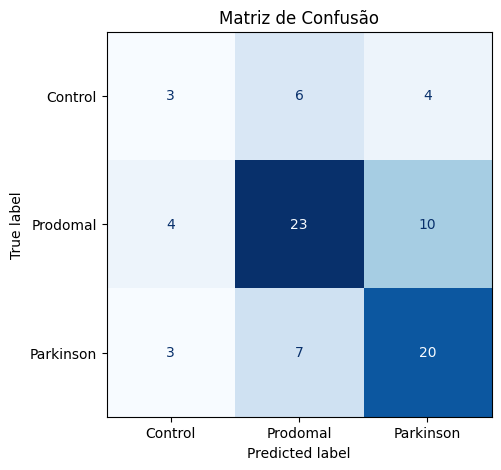

In [14]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

Train Report:               precision    recall  f1-score   support

           0      1.000     1.000     1.000        53
           1      1.000     1.000     1.000       146
           2      1.000     1.000     1.000       121

    accuracy                          1.000       320
   macro avg      1.000     1.000     1.000       320
weighted avg      1.000     1.000     1.000       320



Text(0.5, 1.0, 'Matriz de Confusão')

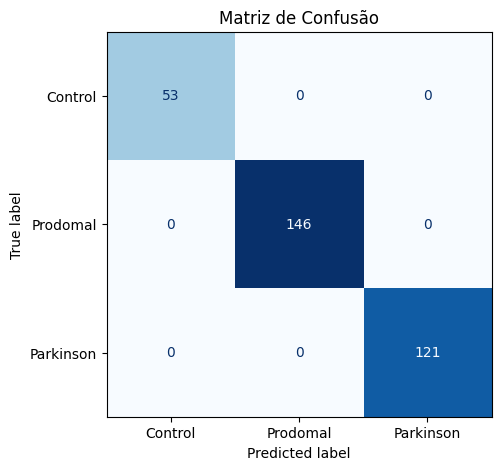

In [15]:
y_pred_train = search.best_estimator_.predict(X_train)
print('Train Report:', classification_report(y_train, y_pred_train, digits=3))
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

## Logistic Regression with SMOTE

In [10]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [24]:
param_dist = {'model__C': np.logspace(-3, 3, 13), 'model__solver': ['lbfgs','saga']}


In [25]:
pipe = ImbPipeline(steps=[
    ("smote", SMOTE(
        sampling_strategy={0: 151},                  
        k_neighbors=5
    )),
    ("model", LogisticRegression(
        max_iter=5000,
        class_weight=None
    )),
])

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(pipe, param_dist, n_iter=20, cv=cv, scoring='f1_macro', n_jobs=4, random_state=42, verbose=1, return_train_score=True)
search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('smote',
                                              SMOTE(sampling_strategy={0: 151})),
                                             ('model',
                                              LogisticRegression(max_iter=5000))]),
                   n_iter=20, n_jobs=4,
                   param_distributions={'model__C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                                        'model__solver': ['lbfgs', 'saga']},
                   random_state=42, return_train_score=True, scoring='f1_macro',
                   verbose=1)

              precision    recall  f1-score   support

           0      0.467     0.538     0.500        13
           1      0.703     0.703     0.703        37
           2      0.643     0.600     0.621        30

    accuracy                          0.637        80
   macro avg      0.604     0.614     0.608        80
weighted avg      0.642     0.637     0.639        80



Text(0.5, 1.0, 'Matriz de Confusão')

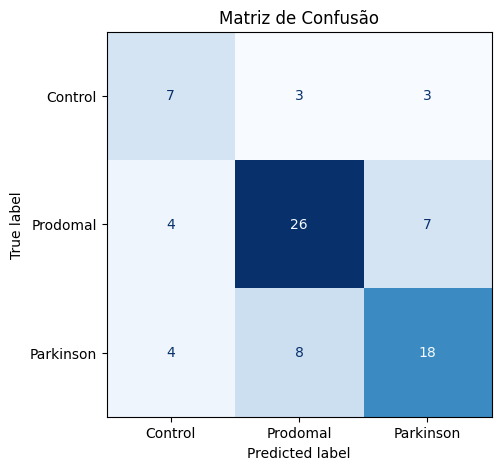

In [28]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

Train Report:               precision    recall  f1-score   support

           0      1.000     1.000     1.000        53
           1      1.000     1.000     1.000       146
           2      1.000     1.000     1.000       121

    accuracy                          1.000       320
   macro avg      1.000     1.000     1.000       320
weighted avg      1.000     1.000     1.000       320



Text(0.5, 1.0, 'Matriz de Confusão')

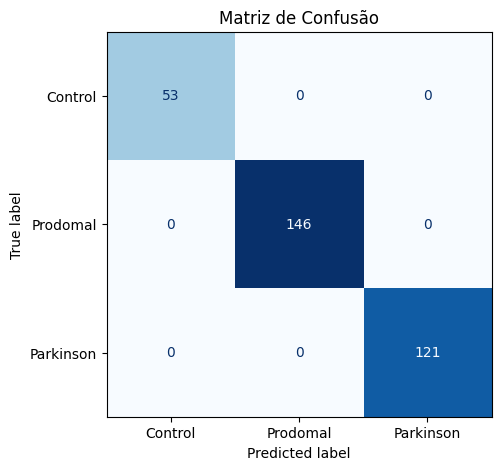

In [29]:
y_pred_train = search.best_estimator_.predict(X_train)
print('Train Report:', classification_report(y_train, y_pred_train, digits=3))
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

## LR with PCA and SMOTE

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import loguniform, uniform

In [35]:

pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler(with_mean=True)),
    ("pca", PCA( whiten=True, random_state=42)),  # 85–95% var is typical
    ("smote", SMOTE(
        sampling_strategy={0: 153},   # upsample class 0 a bit; adjust to your counts
        k_neighbors=5,
        random_state=42
    )),
    ("clf", LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.2,           # try 0.1–0.5; encourages sparsity
        max_iter=5000,
        random_state=42
    )),
])

In [36]:
param_dist = {
    "pca__n_components": np.linspace(0.5, 0.95, num=10),   # 0.85–0.95 explained variance
    "clf__C": np.logspace(-3, 3, 13),            # smaller C = stronger regularization
    "clf__l1_ratio": np.linspace(0.05, 0.45, num=5)        # 0.05–0.5
}

In [37]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(pipe, param_dist, n_iter=60, cv=cv, scoring='f1_macro', n_jobs=4, random_state=42, verbose=1, return_train_score=True)
search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca',
                                              PCA(random_state=42,
                                                  whiten=True)),
                                             ('smote',
                                              SMOTE(random_state=42,
                                                    sampling_strategy={0: 153})),
                                             ('clf',
                                              LogisticRegression(l1_ratio=0.2,
                                                                 max_iter=5000,
                                                                 penalty='elasticnet',
                                                                 random_state=42,
                                                                 solver='saga'))]),
                   n_iter=60...
                   param_distributions={'clf__C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                                        'clf__l1_ratio': array([0.05, 0.15, 0.25, 0.35, 0.45]),
                                        'pca__n_components': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
                   random_state=42, return_train_score=True, scoring='f1_macro',
                   verbose=1)

              precision    recall  f1-score   support

           0      0.438     0.538     0.483        13
           1      0.610     0.676     0.641        37
           2      0.609     0.467     0.528        30

    accuracy                          0.575        80
   macro avg      0.552     0.560     0.551        80
weighted avg      0.581     0.575     0.573        80



Text(0.5, 1.0, 'Matriz de Confusão')

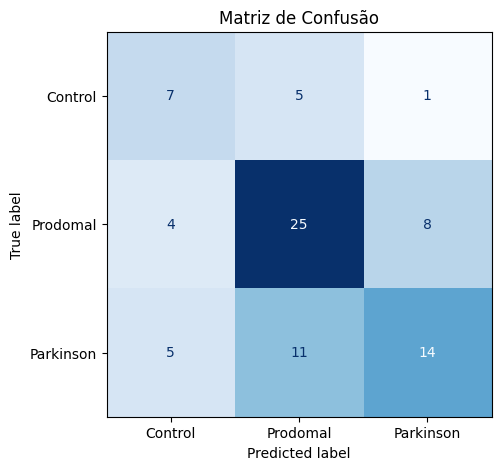

In [38]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

Train Report:               precision    recall  f1-score   support

           0      0.730     0.868     0.793        53
           1      0.910     0.897     0.903       146
           2      0.885     0.826     0.855       121

    accuracy                          0.866       320
   macro avg      0.842     0.864     0.850       320
weighted avg      0.871     0.866     0.867       320



Text(0.5, 1.0, 'Matriz de Confusão')

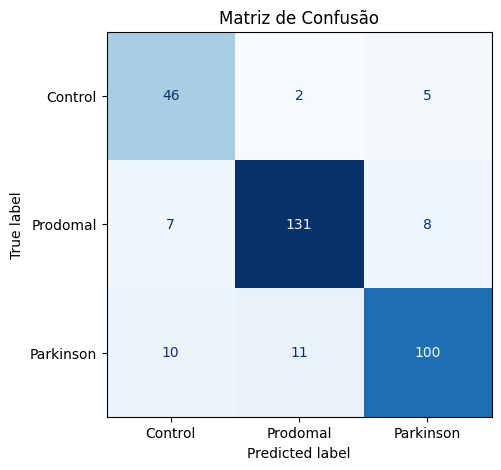

In [39]:
y_pred_train = search.best_estimator_.predict(X_train)
print('Train Report:', classification_report(y_train, y_pred_train, digits=3))
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')

In [ ]:
param_dist = {
  'n_estimators': [100, 200, 500],
  'max_depth': [None, 5, 10, 20],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(rf, param_dist, cv=cv, scoring='f1_macro', n_jobs=8)
search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=8,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1_macro')

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        13
           1      0.532     0.676     0.595        37
           2      0.515     0.567     0.540        30

    accuracy                          0.525        80
   macro avg      0.349     0.414     0.378        80
weighted avg      0.439     0.525     0.478        80



/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Text(0.5, 1.0, 'Matriz de Confusão')

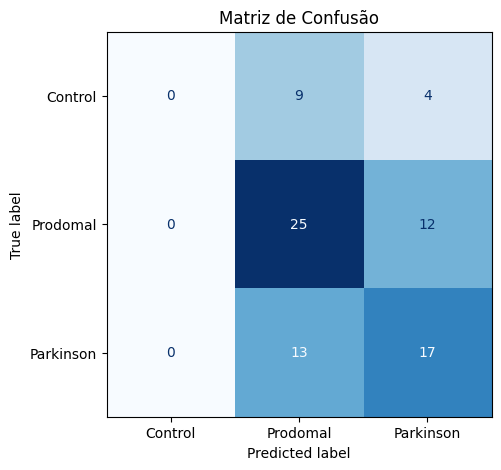

In [51]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

## SVM


In [70]:
from sklearn.svm import SVC

In [71]:
svm = SVC(class_weight='balanced')

In [72]:
param_dist = {
  'C': np.logspace(-3, 3, 13),
  'kernel': ['linear', 'rbf'],
}

In [74]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(svm, param_dist, cv=cv, scoring='f1_macro', n_jobs=8)
search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=8,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                         'kernel': ['linear', 'rbf']},
             scoring='f1_macro')

              precision    recall  f1-score   support

           0      0.500     0.077     0.133        13
           1      0.636     0.568     0.600        37
           2      0.467     0.700     0.560        30

    accuracy                          0.537        80
   macro avg      0.534     0.448     0.431        80
weighted avg      0.551     0.537     0.509        80



Text(0.5, 1.0, 'Matriz de Confusão')

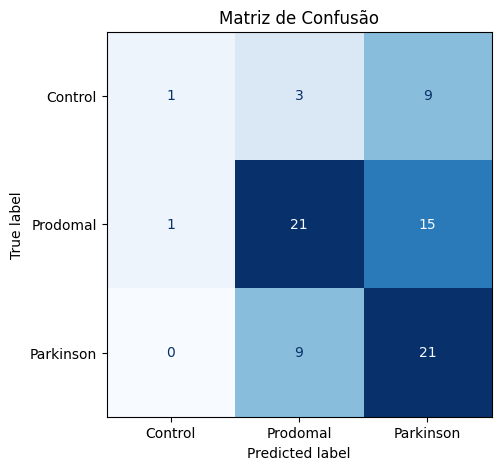

In [75]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

## XGBoost

In [1]:
from xgboost import XGBClassifier

In [8]:
param_dist = {
  'max_depth': [3, 5, 7],
  'eta': [0.1, 0.2, 0.3],
  'subsample': [0.7, 0.85, 1.0],
}

In [9]:
xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric="mlogloss",
    num_class=(len(np.unique(y))))

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(xgb, param_dist, cv=cv, scoring='f1_macro', n_jobs=3, n_iter=20, random_state=42)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=Non...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=3, ...),
                   n_iter=20, n_jobs=3,
                   param_distributions={'eta': [0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7],
                                        'subsample': [0.7, 0.85, 1.0]},
                   random_state=42, scoring='f1_macro')

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        13
           1      0.551     0.730     0.628        37
           2      0.533     0.533     0.533        30

    accuracy                          0.537        80
   macro avg      0.361     0.421     0.387        80
weighted avg      0.455     0.537     0.490        80



Text(0.5, 1.0, 'Matriz de Confusão')

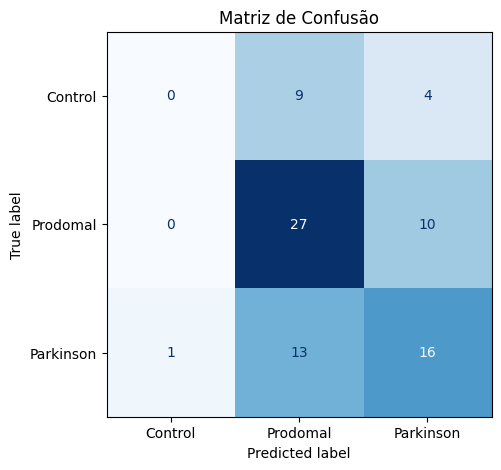

In [15]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")